# Set Up

In [1]:
import sys
sys.path.append('../../Modules/')
sys.path.append('../../Modules/Processors from Prof')
from Packages import *
from My_CSV_processor import *
from Semantic_functions import *
from Wordcloud import *

# Import processors from Prof
from ipynb.fs.full.Utilities import *
from ipynb.fs.full.Json_Processor import *
from ipynb.fs.full.CSV_Processor import *

# Get Data

In [2]:
farel_bench = FarelBench_CSV_Processor_my('Farel-Bench', 'farel_bench.csv').convert_df()

In [3]:
farel_bench['topic'].unique()

array(['child', 'parent', 'grandchild', 'sibling', 'grandparent',
       'great grandchild', 'niece or nephew', 'aunt or uncle',
       'great grandparent', 'great great grandchild',
       'grand-niece or grand-nephew', '1st cousin',
       'grand-aunt or grand-uncle', 'great great grandparent',
       '3rd great grandchild', 'great grand-niece or great grand-nephew',
       '1st cousin 1x removed', 'great grand-aunt or great grand-uncle',
       '3rd great grandparent'], dtype=object)

# WordCloud

In [4]:
text = build_text_from_questions(farel_bench, write_to = None, remove_stopwords = True)

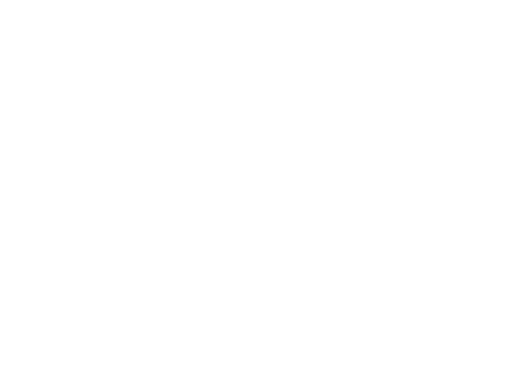

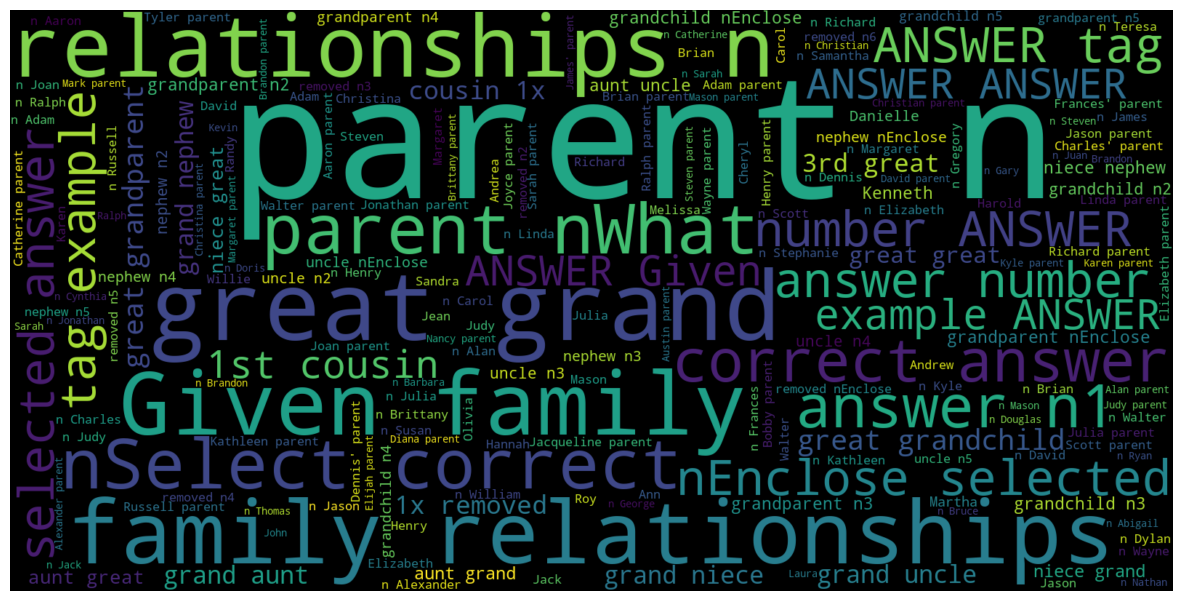

In [5]:
wc = Wordcloud()
wc.generate01(benchmark_name="Farel-Bench", text=text, myStopwords = None, file_name = "wordcloud")

# Word Sense Disambiguation (WSD)

In [6]:
text = build_text_from_questions(farel_bench)

In [7]:
wsd_farel_bench = auto_wsd(farel_bench)

In [8]:
wsd_farel_bench

{'relationship': {'relationship.n.03': 1000},
 '1': {'one.s.01': 1000},
 'family': {'syndicate.n.01': 1000},
 'Given': {'given.s.01': 1000},
 'example': {'model.n.07': 1000},
 'ANSWER': {'solution.n.02': 1000},
 'tag': {'tag.v.03': 1000},
 'selected': {'choose.v.01': 1000},
 'number': {'phone_number.n.01': 1000},
 'correct': {'correct.v.08': 1000},
 'answer': {'solution.n.02': 1000},
 'John': {'whoremaster.n.01': 5},
 'Charlotte': {'charlotte.n.02': 67},
 'Wayne': {'wayne.n.02': 10},
 'Judith': {'judith.n.02': 58},
 'Henry': {'henry.n.03': 70},
 'Charles': {'charles.n.09': 57},
 'Heather': {'heather_mixture.n.01': 68},
 'Frances': {'france.n.01': 81},
 'Amber': {'amber.s.01': 56},
 'Grace': {'seemliness.n.01': 54},
 'Ruth': {'ruth.n.04': 11},
 'Jacob': {'jacob.n.02': 16},
 'Bryan': {'bryan.n.02': 10},
 'Eugene': {'eugene.n.02': 6},
 'Benjamin': {'benzoin.n.01': 29},
 'Joshua': {'joshua.n.02': 4},
 'Victoria': {'victoria.n.06': 68},
 'Christian': {'christian.n.01': 73},
 'David': {'davi

In [9]:
len(wsd_farel_bench)

71

In [10]:
get_synset_def('solution.n.02')

a statement that solves a problem or explains how to solve the problem


# Semantic Role Labeling (SRL)
Assigns roles to words in a sentence (who did what to whom, when, and how).
Example: "John gave Mary a book."
Agent (Who?): John
Action (What Happened?): Gave
Recipient (To Whom?): Mary
Object (What?): A book


Latent Semantic Analysis (LSA)
Captures hidden relationships between words in a large text corpus using Singular Value Decomposition (SVD).
Use Case: Document similarity, topic modeling.
Example:
"Car" and "Automobile" are grouped as related words based on their occurrences in different contexts.
Libraries: scikit-learn, gensim

# Word Embeddings (Word2Vec, GloVe, FastText)
- Represents words as dense vectors, capturing meaning based on usage.

- Libraries: gensim, spaCy

Example:
Word2Vec captures similarity:
vec("king") - vec("man") + vec("woman") ≈ vec("queen")

In [11]:
from gensim.models import KeyedVectors

# Load pre-trained Word2Vec embeddings
model = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin", binary=True)

# Check similarity
print(model.similarity("car", "automobile"))  # High similarity
print(model.similarity("car", "banana"))  # Low similarity

FileNotFoundError: [Errno 2] No such file or directory: 'GoogleNews-vectors-negative300.bin'

In [16]:
model=genai.GenerativeModel(
    model_name="gemini-1.5-flash",)

In [17]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

words = ["king", "queen", "man", "woman", "car", "bus", "apple", "banana"]
word_vectors = [model[word] for word in words]

tsne = TSNE(n_components=2)
reduced_vectors = tsne.fit_transform(word_vectors)

plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1])
for i, word in enumerate(words):
    plt.annotate(word, (reduced_vectors[i, 0], reduced_vectors[i, 1]))
plt.show()


TypeError: 'GenerativeModel' object is not subscriptable